# Imports & display settings

In [ ]:
# Cell 1: imports and display tweaks
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# plotting defaults
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10,5)
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

print("Imports complete.")


Imports complete.


# Load the cleaned dataset

In [3]:
# Cell 2: load data
DATA_PATH = "../data/processed/insurance_cleaned.csv"  # adjust if different

# Try robust read: infer date column if present
parse_cols = []
if os.path.exists(DATA_PATH):
    # attempt to parse TransactionMonth-like columns if present
    try:
        df = pd.read_csv(DATA_PATH, low_memory=False)
        # try convert TransactionMonth if exists
        if "TransactionMonth" in df.columns:
            df["TransactionMonth"] = pd.to_datetime(df["TransactionMonth"], errors="coerce")
        # ensure numeric TotalPremium / TotalClaims
        for c in ["TotalPremium", "TotalClaims"]:
            if c in df.columns:
                df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0.0)
        print("Loaded:", DATA_PATH)
        print("Rows:", len(df))
        display(df.head())
    except Exception as e:
        raise RuntimeError(f"Failed to read {DATA_PATH}: {e}")
else:
    raise FileNotFoundError(f"{DATA_PATH} not found. Update DATA_PATH in the notebook.")


Loaded: ../data/processed/insurance_cleaned.csv
Rows: 1000098


,UnderwrittenCoverID,PolicyID,transaction_date,TotalPremium,TotalClaims,has_claim,loss_ratio,margin,Province,PostalCode,Gender,VehicleType,make,Model
0,145249,12827,2015-03-01,21.929825,0.0,0,0.0,21.929825,Gauteng,1459,Not specified,Passenger Vehicle,MERCEDES-BENZ,E 240
1,145249,12827,2015-05-01,21.929825,0.0,0,0.0,21.929825,Gauteng,1459,Not specified,Passenger Vehicle,MERCEDES-BENZ,E 240
2,145249,12827,2015-07-01,0.000000,0.0,0,NaN,0.000000,Gauteng,1459,Not specified,Passenger Vehicle,MERCEDES-BENZ,E 240
3,145255,12827,2015-05-01,512.848070,0.0,0,0.0,512.848070,Gauteng,1459,Not specified,Passenger Vehicle,MERCEDES-BENZ,E 240
4,145255,12827,2015-07-01,0.000000,0.0,0,NaN,0.000000,Gauteng,1459,Not specified,Passenger Vehicle,MERCEDES-BENZ,E 240


# Quick sanity & create helper columns

In [4]:
# Cell 3: quick sanity checks + helper columns
# I define:
#  - has_claim: True if TotalClaims > 0
#  - margin: TotalPremium - TotalClaims

if "TotalClaims" not in df.columns or "TotalPremium" not in df.columns:
    raise KeyError("Dataset must include 'TotalClaims' and 'TotalPremium' columns.")

df["has_claim"] = df["TotalClaims"].astype(float) > 0
df["margin"] = df["TotalPremium"].astype(float) - df["TotalClaims"].astype(float)

print("Columns available:", df.columns.tolist())
print("Overall rows:", len(df))
print("Overall proportion with a claim:", df["has_claim"].mean())


Columns available: ['UnderwrittenCoverID', 'PolicyID', 'transaction_date', 'TotalPremium', 'TotalClaims', 'has_claim', 'loss_ratio', 'margin', 'Province', 'PostalCode', 'Gender', 'VehicleType', 'make', 'Model']
Overall rows: 1000098
Overall proportion with a claim: 0.002787726802773328


# Aggregate metrics by Province

In [6]:
# Cell 4: aggregate by Province
group_col = "Province"
if group_col not in df.columns:
    raise KeyError(f"Column '{group_col}' not found in data.")

# Option 1: Do it in two steps
# Step 1: Basic aggregations
agg_basic = df.groupby(group_col).agg(
    total_policies=("has_claim", "size"),
    claims_count=("has_claim", "sum"),
    freq=("has_claim", "mean"),
    mean_margin=("margin", "mean")
).reset_index()

# Step 2: Compute severity separately
# Only for policies with claims
severity_df = df[df["has_claim"] == 1].groupby(group_col)["TotalClaims"].mean().reset_index()
severity_df = severity_df.rename(columns={"TotalClaims": "mean_severity"})

# Merge everything
agg = pd.merge(agg_basic, severity_df, on=group_col, how="left")
agg["mean_severity"] = agg["mean_severity"].fillna(0)  # Fill NaN with 0 for provinces with no claims

# Sort by total_policies descending
agg = agg.sort_values("total_policies", ascending=False)
display(agg.head(15))

,Province,total_policies,claims_count,freq,mean_margin,mean_severity
2,Gauteng,393865,1322,0.003356,-13.558894,22243.878396
8,Western Cape,170796,370,0.002166,-3.414689,28095.849881
3,KwaZulu-Natal,169781,483,0.002845,-6.433598,29609.487473
6,North West,143287,349,0.002436,10.958832,16963.467035
5,Mpumalanga,52718,128,0.002428,15.016059,15979.553421
0,Eastern Cape,30336,50,0.001648,25.833240,27128.533277
4,Limpopo,24836,67,0.002698,20.971484,15171.294187
1,Free State,8099,11,0.001358,20.550805,32265.661085
7,Northern Cape,6380,8,0.001254,35.590527,11186.313596


# Visualization: Frequency bar by Province

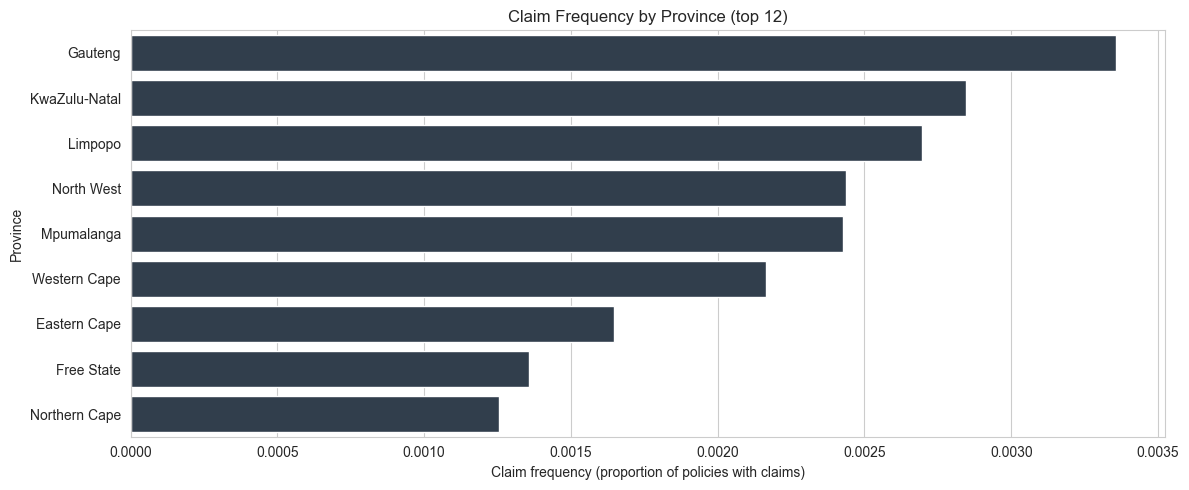

In [ ]:
# Cell 5: Frequency bar chart by province (top 12 shown)
top = agg.sort_values("freq", ascending=False).head(12)

plt.figure(figsize=(12,5))

# Single color for all bars
sns.barplot(data=top, x="freq", y="Province", color="#2c3e50")

plt.title("Claim Frequency by Province (top 12)")
plt.xlabel("Claim frequency (proportion of policies with claims)")
plt.ylabel("Province")

# Format to 4 decimal places
from matplotlib.ticker import FormatStrFormatter
plt.gca().xaxis.set_major_formatter(FormatStrFormatter('%.4f'))

plt.tight_layout()
plt.show()

#  Visualization: Mean severity and margin (dual chart)

C:\Users\bethy\AppData\Local\Temp\ipykernel_28384\329924172.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_by_count, x="mean_severity", y="Province", ax=axes[0], palette="rocket")
C:\Users\bethy\AppData\Local\Temp\ipykernel_28384\329924172.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_by_count, x="mean_margin", y="Province", ax=axes[1], palette="mako")


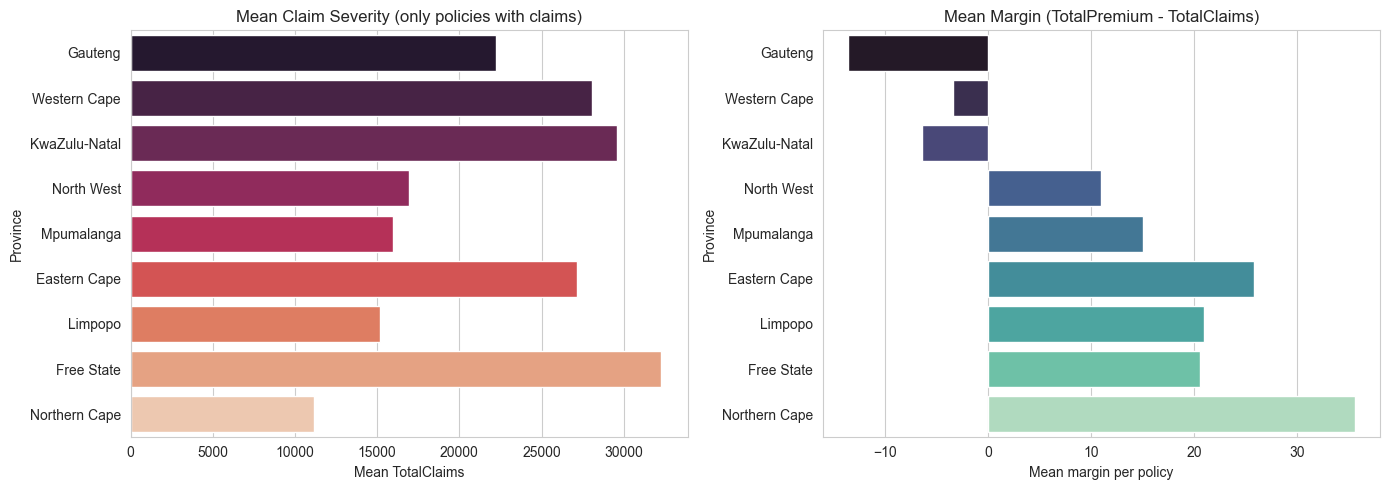

In [ ]:
# Cell 6: Dual chart -> mean severity and mean margin for top provinces by count
top_by_count = agg.sort_values("total_policies", ascending=False).head(10).copy()
fig, axes = plt.subplots(1,2, figsize=(14,5))

sns.barplot(data=top_by_count, x="mean_severity", y="Province", ax=axes[0], palette="rocket")
axes[0].set_title("Mean Claim Severity (only policies with claims)")
axes[0].set_xlabel("Mean TotalClaims")

sns.barplot(data=top_by_count, x="mean_margin", y="Province", ax=axes[1], palette="mako")
axes[1].set_title("Mean Margin (TotalPremium - TotalClaims)")
axes[1].set_xlabel("Mean margin per policy")

plt.tight_layout()
plt.show()


 # Stat test 1: Claim frequency across provinces (chi-square)

In [14]:
# Cell 7: Chi-square test for claim frequency across provinces
from scipy.stats import chi2_contingency

# Build contingency: rows = provinces, cols = [no_claim, claim]
prov_counts = df.groupby("Province")["has_claim"].value_counts().unstack(fill_value=0)
prov_counts = prov_counts.loc[agg["Province"]]  # keep same order as agg
display(prov_counts.head())

chi2, p, dof, expected = chi2_contingency(prov_counts.values)
print(f"Chi-square: chi2={chi2:.3f}, p={p:.4f}, dof={dof}")
if p < 0.05:
    print("=> Reject H0: claim frequency differs across provinces.")
else:
    print("=> Fail to reject H0: no evidence of difference in claim frequency across provinces.")


has_claim,False,True
Province,,
Gauteng,392543,1322
Western Cape,170426,370
KwaZulu-Natal,169298,483
North West,142938,349
Mpumalanga,52590,128


Chi-square: chi2=104.191, p=0.0000, dof=8
=> Reject H0: claim frequency differs across provinces.


# Stat test 1b: Severity differences across provinces (Levene + Kruskal-Wallis)

In [15]:
# Cell 8: Test severity (only among policies with claims)
claims = df[df["has_claim"]].copy()
groups = [group["TotalClaims"].dropna().values for name, group in claims.groupby("Province") if len(group) > 0]

# Levene test for equal variances across groups
levene_stat, levene_p = stats.levene(*[g for g in groups if len(g)>0], center='median')
print("Levene test for equal variances: p =", levene_p)

# Use non-parametric Kruskal-Wallis (safer for skewed data)
kruskal_stat, kruskal_p = stats.kruskal(*[g for g in groups if len(g)>0])
print("Kruskal-Wallis: stat = {:.3f}, p = {:.4f}".format(kruskal_stat, kruskal_p))

if kruskal_p < 0.05:
    print("=> Reject H0: severity differs among provinces (non-parametric).")
else:
    print("=> Fail to reject H0: no strong evidence severity differs among provinces.")


Levene test for equal variances: p = 0.0008641010299238739
Kruskal-Wallis: stat = 106.093, p = 0.0000
=> Reject H0: severity differs among provinces (non-parametric).


# Top postal codes (counts) + visualization

Top postal codes sample sizes:
 PostalCode
2000    133498
122      49171
7784     28585
299      25546
7405     18518
458      13775
8000     11794
2196     11048
470      10226
7100     10161
1724     10107
4360      9730
Name: count, dtype: int64


C:\Users\bethy\AppData\Local\Temp\ipykernel_28384\3125871914.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_zips.values, y=top_zips.index, palette="cubehelix")


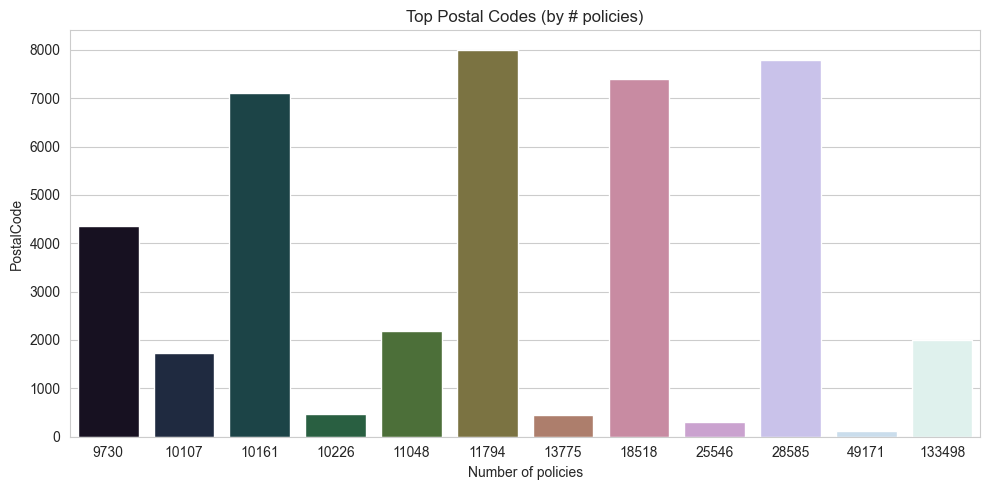

In [ ]:
# Cell 9: Top postal codes by number of records
zip_col = "PostalCode"
if zip_col not in df.columns:
    print(f"Column {zip_col} not found; skipping zip-code analysis.")
else:
    top_zips = df[zip_col].value_counts().head(12)
    print("Top postal codes sample sizes:\n", top_zips)
    plt.figure(figsize=(10,5))
    sns.barplot(x=top_zips.values, y=top_zips.index, palette="cubehelix")
    plt.title("Top Postal Codes (by # policies)")
    plt.xlabel("Number of policies")
    plt.ylabel("PostalCode")
    plt.tight_layout()
    plt.show()


# Stat test 2: Frequency & margin for top zip codes 

In [ ]:
# Cell 10: Choose top N postal codes and test differences
if zip_col in df.columns:
    top_n = 10
    top_codes = df[zip_col].value_counts().nlargest(top_n).index.tolist()
    sample = df[df[zip_col].isin(top_codes)].copy()
    # contingency for frequency across top zip codes
    zip_counts = sample.groupby(zip_col)["has_claim"].value_counts().unstack(fill_value=0)
    display(zip_counts)
    chi2, p, dof, expected = chi2_contingency(zip_counts.values)
    print(f"Chi-square (top {top_n} zip codes): chi2={chi2:.3f}, p={p:.4f}")
    # margin distribution across top zip codes (non-parametric)
    groups_margin = [g["margin"].dropna().values for n,g in sample.groupby(zip_col)]
    kw_stat, kw_p = stats.kruskal(*[g for g in groups_margin if len(g)>0])
    print("Kruskal-Wallis margin: stat={:.3f}, p={:.4f}".format(kw_stat, kw_p))
else:
    print("PostalCode not present — skipped.")


has_claim,False,True
PostalCode,,
122,48961,210
299,25479,67
458,13743,32
470,10182,44
2000,133012,486
2196,11016,32
7100,10133,28
7405,18489,29
7784,28535,50


Chi-square (top 10 zip codes): chi2=72.649, p=0.0000
Kruskal-Wallis margin: stat=4931.140, p=0.0000


# Gender analysis: counts + frequency + severity boxplot

Gender counts:
 Gender
Not specified    940990
Male              42817
NaN                9536
Female             6755
Name: count, dtype: int64

Claim frequency by gender:
 Gender
Not specified    0.002833
Male             0.002195
Female           0.002073
Name: has_claim, dtype: float64


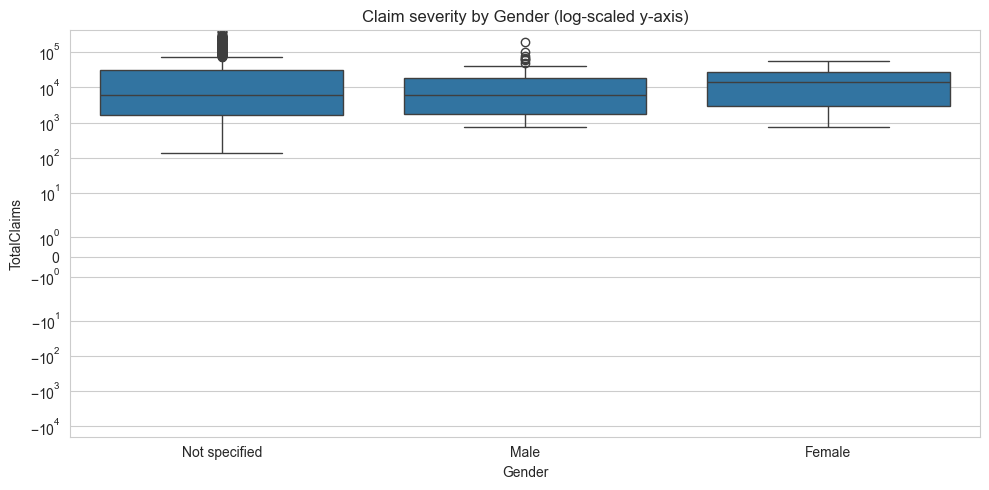

In [ ]:
# Cell 11: Gender breakdown and quick plots
gcol = "Gender"
if gcol in df.columns:
    gender_counts = df[gcol].fillna("NaN").value_counts()
    print("Gender counts:\n", gender_counts)
    # frequency by gender
    freq_by_gender = df.groupby(gcol)["has_claim"].mean().sort_values(ascending=False)
    print("\nClaim frequency by gender:\n", freq_by_gender)
    # severity boxplot (only among claims)
    plt.figure(figsize=(10,5))
    sns.boxplot(data=df[df["has_claim"]], x=gcol, y="TotalClaims")
    plt.yscale("symlog")  # use symlog to show skew but cap huge outliers visually
    plt.title("Claim severity by Gender (log-scaled y-axis)")
    plt.tight_layout()
    plt.show()
else:
    print("Gender column not found; skipping gender analysis.")


# Stat test 3: Frequency / severity by gender

In [19]:
# Cell 12: Stats for gender differences
if gcol in df.columns:
    # Chi-square for frequency
    ct = pd.crosstab(df[gcol].fillna("NaN"), df["has_claim"])
    display(ct)
    chi2, p, dof, _ = chi2_contingency(ct.values)
    print(f"Chi-square frequency by gender: chi2={chi2:.3f}, p={p:.4f}")
    # For severity, compare two groups if desired; pick 'Male' vs 'Female' if exists
    groups = df[df["has_claim"]].groupby(gcol)["TotalClaims"].apply(list)
    if "Male" in groups.index and "Female" in groups.index:
        male = np.array(groups["Male"])
        female = np.array(groups["Female"])
        # Levene
        lv_stat, lv_p = stats.levene(male, female, center='median')
        print("Levene variance p =", lv_p)
        t_stat, t_p = stats.ttest_ind(male, female, equal_var=(lv_p>0.05))
        # effect size (Cohen's d)
        pooled_sd = np.sqrt(((male.std(ddof=1)**2) + (female.std(ddof=1)**2))/2)
        cohen_d = (male.mean() - female.mean()) / pooled_sd if pooled_sd>0 else np.nan
        print(f"t-test: stat={t_stat:.3f}, p={t_p:.4f}, cohen_d={cohen_d:.3f}")
    else:
        print("Not enough Male/Female records to run direct t-test; use group comparisons or report counts.")
else:
    print("Gender column not found; skipping statistical tests.")


has_claim,False,True
Gender,,
Female,6741,14
Male,42723,94
NaN,9522,14
Not specified,938324,2666


Chi-square frequency by gender: chi2=13.320, p=0.0040
Levene variance p = 0.9439561119569472
t-test: stat=-0.419, p=0.6760, cohen_d=-0.138


# Interpretation helper: short summary prints

In [20]:
# Cell 13: Print concise interpretation for each test
print("=== Interpretation summary ===\n")

# Province frequency
chi2_p = chi2_contingency(prov_counts.values)[1]
print(f"Province frequency p-value: {chi2_p:.4g}")
if chi2_p < 0.05:
    print("- Claim frequency differs by province (recommend regional pricing adjustments).")
else:
    print("- No strong evidence of frequency differences by province.")

# Province severity (kruskal_p from cell 9)
print(f"\nProvince severity Kruskal p: {kruskal_p:.4g}")
if kruskal_p < 0.05:
    print("- Claim severity differs by province (investigate high-severity provinces).")
else:
    print("- No strong evidence severity differs by province.")

# Top zips
if zip_col in df.columns:
    print(f"\nTop postal codes frequency p: {p:.4g} (chi-square earlier)")
    print("- Top postal codes differ — consider location-based interventions/pricing.")
# Gender
if gcol in df.columns:
    print(f"\nGender frequency p (chi-square): {chi2:.4g}")
    print("- Gender shows statistical differences but check sample sizes & missingness before acting.")


=== Interpretation summary ===

Province frequency p-value: 5.926e-19
- Claim frequency differs by province (recommend regional pricing adjustments).

Province severity Kruskal p: 2.415e-19
- Claim severity differs by province (investigate high-severity provinces).

Top postal codes frequency p: 0.003994 (chi-square earlier)
- Top postal codes differ — consider location-based interventions/pricing.

Gender frequency p (chi-square): 13.32
- Gender shows statistical differences but check sample sizes & missingness before acting.


# export summary CSV for reporting

In [21]:
# Cell 14: Save aggregated summaries to CSV for inclusion in reports
out_dir = "reports"
os.makedirs(out_dir, exist_ok=True)
agg.to_csv(os.path.join(out_dir, "province_risk_summary.csv"), index=False)
if zip_col in df.columns:
    zip_summary = df.groupby(zip_col).agg(total_policies=("has_claim","size"),
                                         claims_count=("has_claim","sum"),
                                         freq=("has_claim","mean"),
                                         mean_margin=("margin","mean")).reset_index().sort_values("total_policies", ascending=False)
    zip_summary.to_csv(os.path.join(out_dir, "zip_risk_summary.csv"), index=False)
print("Saved province and zip summaries to reports/ folder.")


Saved province and zip summaries to reports/ folder.
